# Lesson 6: Essay Writer

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [4]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [5]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

In [6]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [7]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

In [8]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [9]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


In [10]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


In [11]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

C:\Users\patel\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [13]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [14]:
def research_plan_node(state):
    queries = state.get("queries", [])
    content = []

    for q in queries:
        response = tavily.search(query=q, max_results=2)

        # Ensure the response is a list of dictionaries (or handle it properly)
        if isinstance(response, list):
            for item in response:
                if isinstance(item, dict) and 'content' in item:
                    content.append(item['content'])
                else:
                    print(f"Unexpected item format: {item}")
        else:
            print(f"Unexpected response format: {response}")

    return {**state, 'content': content}


In [15]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }


In [16]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [17]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [18]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [19]:
builder = StateGraph(AgentState)

In [20]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [21]:
builder.set_entry_point("planner")

In [22]:
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)


In [23]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [24]:
graph = builder.compile(checkpointer=memory)

In [25]:
pip show pygraphviz


Name: pygraphviz
Version: 1.14
Summary: Python interface to Graphviz
Home-page: https://pygraphviz.github.io
Author: Manos Renieris
Author-email: Aric Hagberg <aric.hagberg@gmail.com>, Dan Schult <dschult@colgate.edu>
License: BSD-3-Clause
Location: c:\users\patel\anaconda3\envs\venv-langraph\lib\site-packages
Requires: 
Required-by: 
Note: you may need to restart the kernel to use updated packages.


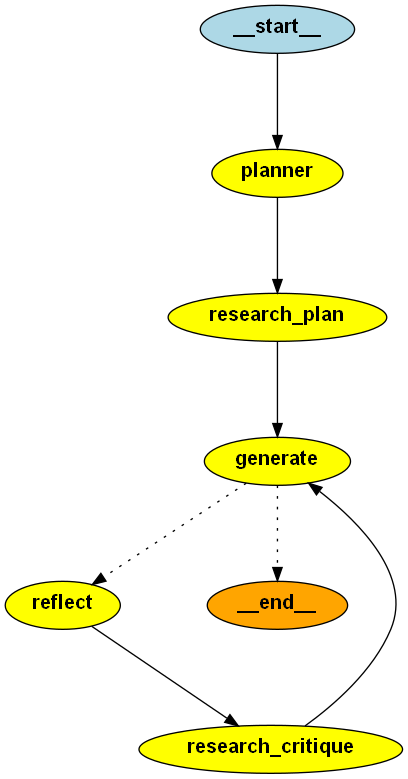

In [26]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [27]:
pip show langgraph

Name: langgraph
Version: 0.2.70
Summary: Building stateful, multi-actor applications with LLMs
Home-page: https://www.github.com/langchain-ai/langgraph
Author: 
Author-email: 
License: MIT
Location: c:\users\patel\anaconda3\envs\venv-langraph\lib\site-packages
Requires: langchain-core, langgraph-checkpoint, langgraph-sdk
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [28]:
def my_node_function(state):
    return {"content": state.get("content", [])}  # Ensure content key exists


In [29]:
state = {"content": ["test"]}
print(my_node_function(state))  # Should print {"content": ["test"]}


{'content': ['test']}


In [30]:
thread = {
    "configurable": {"thread_id": "1"},
    "content": []  # Ensure 'content' key exists from the start
}


In [31]:
# Task parameters
params = {
    'task': "what is the difference between langchain and langsmith",
    "max_revisions": 2,
    "revision_number": 1,
}

# Iterate over the stream
for s in graph.stream(params, thread):
    # Print type and structure of stream item 's'
    print(f"Stream Item Type: {type(s)}")
    
    # If 's' is of type 'AddableUpdatesDict', treat it like a dictionary
    if isinstance(s, dict):
        print(f"Stream Item Content: {s}")
        
        # Accessing the 'planner' key content (if exists)
        if 'planner' in s:
            print(f"Plan: {s['planner']['plan']}")
    else:
        # Handle other data types here (e.g., if 's' is a string or another type)
        print(f"Raw Stream Item: {s}")


Stream Item Type: <class 'langgraph.pregel.io.AddableUpdatesDict'>
Stream Item Content: {'planner': {'plan': 'I. Introduction\n    A. Brief overview of Langchain and Langsmith\n    B. Thesis statement: Exploring the differences between Langchain and Langsmith\n\nII. Langchain\n    A. Definition and explanation\n    B. Key features and characteristics\n    C. Use cases and applications\n    D. Advantages and disadvantages\n\nIII. Langsmith\n    A. Definition and explanation\n    B. Key features and characteristics\n    C. Use cases and applications\n    D. Advantages and disadvantages\n\nIV. Comparison between Langchain and Langsmith\n    A. Technology stack\n    B. Scalability\n    C. Security\n    D. Performance\n    E. Adoption and popularity\n\nV. Conclusion\n    A. Recap of main differences between Langchain and Langsmith\n    B. Implications for the future of blockchain technology\n    C. Final thoughts and recommendations\n\nNotes:\n- Ensure to provide clear definitions and expla

c:\Users\patel\anaconda3\envs\venv-langraph\lib\site-packages\langchain_openai\chat_models\base.py:1362: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
c:\Users\patel\anaconda3\envs\venv-langraph\lib\site-packages\langchain_openai\chat_models\base.py:1375: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


Stream Item Type: <class 'langgraph.pregel.io.AddableUpdatesDict'>
Stream Item Content: {'research_critique': {'content': ['Here’s the deal: LangChain is like building the entire car, while LangSmith is your diagnostic tool to ensure that car runs smoothly. When it comes to practical application, I always say: “Show, don’t tell.” I’ve used both LangChain and LangSmith extensively, and I’ve found that they complement each other beautifully when you’re building and fine-tuning LLM-based workflows. Having spent countless hours building and debugging LLM-based systems, I’ve learned that using LangChain and LangSmith effectively requires a few smart strategies. I often use LangChain to build my pipelines and LangSmith to monitor and debug them. Start with LangChain to build your pipeline, and then bring in LangSmith to ensure it performs as expected.', 'If you’re responsible for ensuring your AI models work in production, or you need to frequently debug and monitor your pipelines, Langsmith

## Essay Writer Interface

In [32]:
import warnings
warnings.filterwarnings("ignore")

from helper import ewriter, writer_gui

In [34]:
MultiAgent = ewriter()
app = writer_gui(MultiAgent.graph)
app.launch()

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "c:\Users\patel\anaconda3\envs\venv-langraph\lib\site-packages\gradio\queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
  File "c:\Users\patel\anaconda3\envs\venv-langraph\lib\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
  File "c:\Users\patel\anaconda3\envs\venv-langraph\lib\site-packages\gradio\blocks.py", line 2088, in process_api
    result = await self.call_function(
  File "c:\Users\patel\anaconda3\envs\venv-langraph\lib\site-packages\gradio\blocks.py", line 1635, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "c:\Users\patel\anaconda3\envs\venv-langraph\lib\site-packages\anyio\to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
  File "c:\Users\patel\anaconda3\envs\venv-langraph\lib\site-packages\anyio\_backends\_asyncio.py", line 2461,